### Metric Learning and Plotting

This is a small walkthrough which illustrates all the Metric Learning algorithms implemented in metric_learn, and also does a quick visualisation which can help understand which algorithm might be best suited for you.

Of course, depending on the data set and the constraints your results will look very different; you can just follow this and change your data and constraints accordingly. 

#### Imports 

In [1]:
%matplotlib inline

import metric_learn
import numpy as np
from sklearn.datasets import load_iris

# visualisation imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Loading our data-set and setting up plotting

We will be using the IRIS data-set to illustrate the plotting. You can read more about the IRIS data-set here: [link](https://en.wikipedia.org/wiki/Iris_flower_data_set). 

We would like to point out that only two features - Sepal Width and Sepal Length are being plotted. This is because it is tough to visualise more features than this. The purpose of the plotting is to understand how each of the new learned metrics transform the input space. 

In [2]:
# loading our dataset

iris_data = load_iris()
# this is our data
X = iris_data['data']
# these are our constraints
Y = iris_data['target']

# function to plot the results
def plot(X, Y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    plt.figure(2, figsize=(8, 6))

    # clean the figure
    plt.clf()

    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()

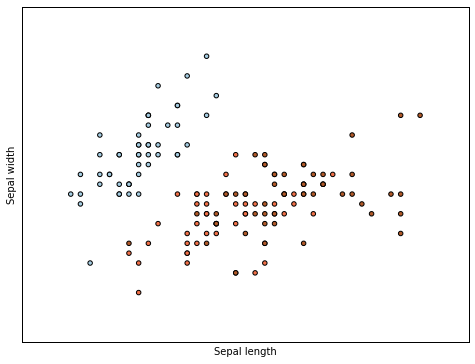

In [3]:
# plotting the dataset as is.
plot(X, Y)

### Metric Learning

Why is Metric Learning useful? We can, with prior knowledge of which points are supposed to be closer, figure out a better way to understand distances between points. Especially in higher dimensions when Euclidean distances are a poor way to measure distance, this becomes very useful.

Basically, we learn this distance:  $D(x,y)=\sqrt{(x-y)\,M^{-1}(x-y)}$.
And we learn this distance by learning a Matrix $M$, based on certain constraints.

Some good reading material for the same can be found [here](https://arxiv.org/pdf/1306.6709.pdf). It serves as a good literature review of Metric Learning. 

We will briefly explain the metric-learning algorithms implemented by metric-learn, before providing some examples for it's usage, and also discuss how to go about doing manual constraints.

Metric-learn can be easily integrated with your other machine learning pipelines, and follows (for the most part) scikit-learn conventions.

### Large Margin Nearest Neighbour

LMNN is a metric learning algorithm primarily designed for k-nearest neighbor classification. The algorithm is based on semidefinite programming, a sub-class of convex programming (as most Metric Learning algorithms are).

The main intuition behind LMNN is to learn a pseudometric under which all data instances in the training set are surrounded by at least k instances that share the same class label. If this is achieved, the leave-one-out error (a special case of cross validation) is minimized. 

You can find the paper [here](http://jmlr.csail.mit.edu/papers/volume10/weinberger09a/weinberger09a.pdf).

#### Fit and then transform!

In [4]:
# setting up LMNN
lmnn = metric_learn.LMNN(k=5, learn_rate=1e-6)

# fit the data!
lmnn.fit(X, Y)

# transform our input space
X_lmnn = lmnn.transform()

So what have we learned? The matrix $M$ we talked about before.
Let's see what it looks like.

In [5]:
lmnn.metric()

array([[ 2.49193844,  0.35638993, -0.39984418, -0.77608969],
       [ 0.35638993,  1.68815388, -0.90376817, -0.07406329],
       [-0.39984418, -0.90376817,  2.37468946,  2.18784107],
       [-0.77608969, -0.07406329,  2.18784107,  2.94523937]])

Now let us plot the transformed space - this tells us what the original space looks like after being transformed with the new learned metric.

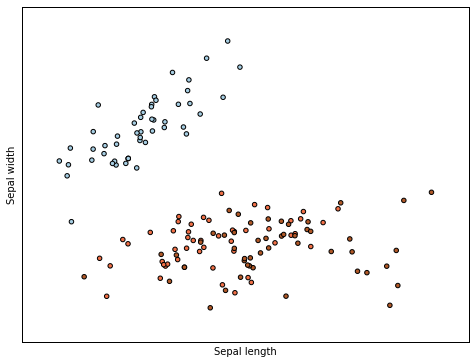

In [6]:
plot(X_lmnn, Y)

Pretty neat, huh?

The rest of this notebook will briefly explain the other Metric Learning algorithms before plottting them.
Also, while we have first run `fit` and then `transform` to see our data transformed, we can also use `fit_transform` if you are using the bleeding edge version of the code. The rest of the examples and illustrations will use `fit_transform`.

###  Information Theoretic Metric Learning 

ITML uses a regularizer that automatically enforces a Semi-Definite Positive Matrix condition - the LogDet divergence. It uses soft must-link or cannot like constraints, and a simple algorithm based on Bregman projections. 

Link to paper: [ITML](http://www.cs.utexas.edu/users/pjain/pubs/metriclearning_icml.pdf). 

In [7]:
itml = metric_learn.ITML_Supervised(num_constraints=200)
X_itml = itml.fit_transform(X, Y)

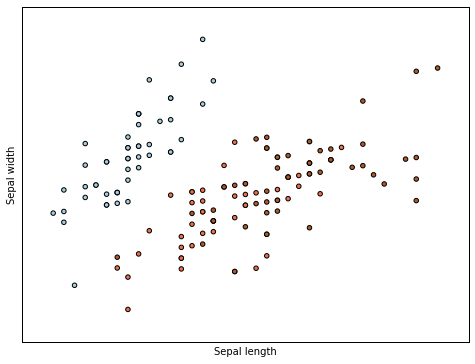

In [8]:
plot(X_itml, Y)

###  Sparse Determinant Metric Learning

Implements an efficient sparse metric learning algorithm in high dimensional space via an $l_1$-penalised log-determinant regularization. Compare to the most existing distance metric learning algorithms, the algorithm exploits the sparsity nature underlying the intrinsic high dimensional feature space.

Link to paper here: [SDML](http://lms.comp.nus.edu.sg/sites/default/files/publication-attachments/icml09-guojun.pdf). 

One feature which we'd like to show off here is the use of random seeds.
Some of the algorithms feature randomised algorithms for selecting constraints - to fix these, and get constant results for each run, we pass a numpy random seed as shown in the example below.

In [9]:
sdml = metric_learn.SDML_Supervised(num_constraints=200, seed = np.random.RandomState(1234))
X_sdml = sdml.fit_transform(X, Y)

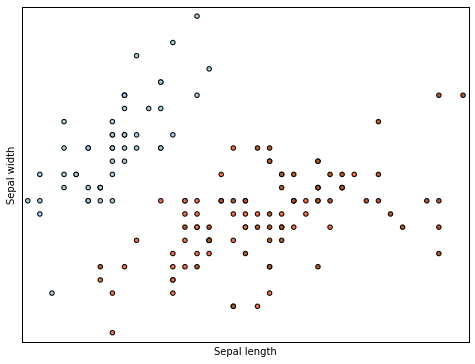

In [10]:
plot(X_sdml, Y)

### Least Squares Metric Learning

LSML is a simple, yet effective, algorithm that learns a Mahalanobis metric from a given set of relative comparisons. This is done by formulating and minimizing a convex loss function that corresponds to the sum of squared hinge loss of violated constraints. 

Link to paper: [LSML](http://web.cs.ucla.edu/~weiwang/paper/ICDM12.pdf)

[TODO: add manual constraints)
For this particular case, we are going to use our own set of constraints.
Normally, the constrains are randomly created, with the constraint classes built into metric-learn.

In [12]:
lsml = metric_learn.LSML_Supervised(num_constraints=200)
X_lsml = lsml.fit_transform(X, Y)

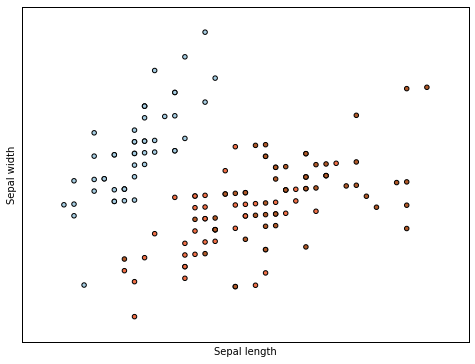

In [13]:
plot(X_lsml, Y)

### Neighborhood Components Analysis

NCA is an extrememly popular metric-learning algorithm, and one of the first few (published back in 2005).

Neighbourhood components analysis aims at "learning" a distance metric by finding a linear transformation of input data such that the average leave-one-out (LOO) classification performance is maximized in the transformed space. The key insight to the algorithm is that a matrix $A$ corresponding to the transformation can be found by defining a differentiable objective function for $A$, followed by use of an iterative solver such as conjugate gradient descent. One of the benefits of this algorithm is that the number of classes $k$ can be determined as a function of $A$, up to a scalar constant. This use of the algorithm therefore addresses the issue of model selection.

You can read more about it in the paper here: [NCA](https://papers.nips.cc/paper/2566-neighbourhood-components-analysis.pdf). 

In [14]:
nca = metric_learn.NCA(max_iter=1000, learning_rate=0.01)
X_nca = nca.fit_transform(X, Y)

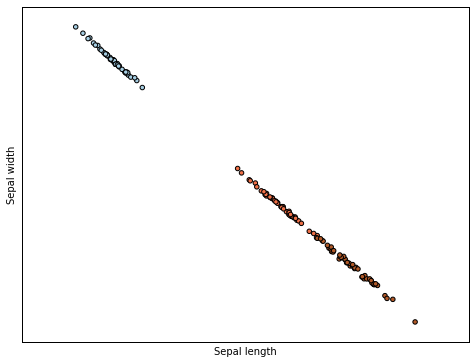

In [15]:
plot(X_nca, Y)

### Local Fischer Discriminant Analysis

LFDA is a linear supervised dimensionality reduction method. It is particularly useful when dealing with multimodality, where one ore more classes consist of separate clusters in input space. The core optimization problem of LFDA is solved as a generalized eigenvalue problem.

Link to paper: [LFDA](http://www.machinelearning.org/proceedings/icml2006/114_Local_Fisher_Discrim.pdf)

In [16]:
lfda = metric_learn.LFDA(k=2, dim=2)
X_lfda = lfda.fit_transform(X, Y)

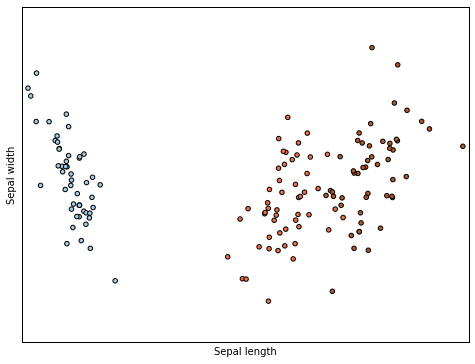

In [17]:
plot(X_lfda, Y)

### Relative Components Analysis

RCA is another one of the older algorithms.
It learns a full rank Mahalanobis distance metric based on a weighted sum of in-class covariance matrices. It applies a global linear transformation to assign large weights to relevant dimensions and low weights to irrelevant dimensions. Those relevant dimensions are estimated using “chunklets”, subsets of points that are known to belong to the same class.

Link to paper: [RCA](https://www.aaai.org/Papers/ICML/2003/ICML03-005.pdf)

In [18]:
rca = metric_learn.RCA_Supervised(num_chunks=30, chunk_size=2)
X_rca = rca.fit_transform(X, Y)

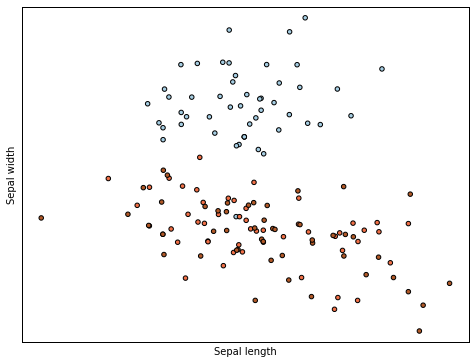

In [19]:
plot(X_rca, Y)